[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass
from dotenv import load_dotenv

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

load_dotenv("../.env")

True

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
# _set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = os.getenv("langchain_api_key")
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("langchain_tracing_v2")
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [5]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o")
# llm.invoke(messages)

from langchain_openai import AzureChatOpenAI

model = AzureChatOpenAI(
    deployment_name = os.getenv("deployment_name"),
    model_name = os.getenv("model_name"),
    azure_endpoint = os.getenv("azure_endpoint"),
    openai_api_key = os.getenv("openai_api_key"),
    openai_api_version = os.getenv("openai_api_version"),
    temperature = 0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [4]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")  # returns "" if not found

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [7]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [15]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

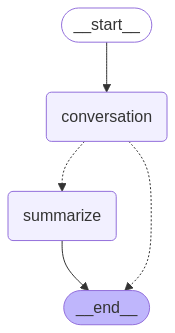

In [16]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [31]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Souvik")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the Fossils! which song by them is your favourite?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, Souvik! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Souvik. How can I help you today, Souvik?
================================== Ai Message ==================================

Fossils is a popular Bengali rock band, and they have many great songs. Some of their well-known tracks include "Hasnuhana," "Ekla Ghor," and "Aro Ekbar." While I don't have personal preferences, many fans enjoy these songs. Which one is your favorite?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [ ]:
graph.get_state(config).values.get("summary","")        # dict.get("key", "") returns "" if no value found for key in dict without throwing an error

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [33]:
input_message = HumanMessage(content="i like anupam roy as well! which song by him is your favourite?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Anupam Roy is a talented singer-songwriter and composer known for his soulful music. Some of his popular songs include "Amake Amar Moto Thakte Dao," "Beche Thakar Gaan," and "Tumi Jake Bhalobasho." While I don't have personal preferences, these songs are widely appreciated by his fans. Do you have a favorite song by Anupam Roy?


In [34]:
graph.get_state(config).values.get("summary","")

'In the conversation, Souvik introduces himself and expresses his liking for the Bengali rock band Fossils. The assistant mentions some popular songs by Fossils, such as "Hasnuhana," "Ekla Ghor," and "Aro Ekbar." Souvik then shares his appreciation for Anupam Roy, and the assistant lists some of Anupam Roy\'s well-known songs, including "Amake Amar Moto Thakte Dao," "Beche Thakar Gaan," and "Tumi Jake Bhalobasho." The conversation revolves around Souvik\'s musical interests.'

In [ ]:
for m in graph.get_state(config).values["messages"]:
    m.pretty_print()

# only the last 2 messages are retained, the rest are deleted as per the logic in summarize_conversation

================================ Human Message =================================

i like anupam roy as well! which song by him is your favourite?
================================== Ai Message ==================================

Anupam Roy is a talented singer-songwriter and composer known for his soulful music. Some of his popular songs include "Amake Amar Moto Thakte Dao," "Beche Thakar Gaan," and "Tumi Jake Bhalobasho." While I don't have personal preferences, these songs are widely appreciated by his fans. Do you have a favorite song by Anupam Roy?


- Let's continue the conversation, from now onwards we should be able to visualize traces in LangSmith that the (summary as system prompt + last two retained messages + new input message) have been passed to the LLM and the answer will be the output.

In [36]:
input_message = HumanMessage(content="i like bhoomi as well! childhood memories! which song by them is your favourite?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Bhoomi is a beloved Bengali band known for their folk-inspired music that resonates with many listeners. Some of their popular songs include "Barandaye Roddur," "Tomar Dekha Nai," and "Pocha Kaka." These songs have a nostalgic charm and are often associated with fond memories for many fans. While I don't have personal preferences, these songs are widely cherished. Do you have a favorite Bhoomi song that brings back special memories for you?


## LangSmith

Let's review the trace!

https://smith.langchain.com/public/f560908b-8a6a-42be-9f63-95d3045cd23c/r